# Beginner's Exploratory Data Analysis for Crypto Market

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cross_decomposition
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set()

# Make charts a bit bolder
#sns.set_context("talk")

%matplotlib inline

# Default figure size
sns.set(rc={"figure.figsize": (12, 6)})

# This actually makes autocomplete WAY faster ...
%config Completer.use_jedi = False

# Show only 2 decimals for floating point numbers
pd.options.display.float_format = "{:.2f}".format

sns.set_style('whitegrid')

In [248]:
data = pd.read_csv('../input/seven-comparison-data/seven_comparison_data.csv')

In [249]:
data.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,apecoin-ape,APE,ApeCoin,11/30/2023,87,1.33,1.78,1.28,1.57,2416492644.41,580382547.44,0.60,0.50
1,apecoin-ape,APE,ApeCoin,10/31/2023,87,1.24,1.43,1.01,1.33,1546371748.00,489411269.85,0.76,0.42
2,apecoin-ape,APE,ApeCoin,09/30/2023,87,1.43,1.44,1.08,1.24,1408465264.21,458736459.99,0.47,0.36
3,apecoin-ape,APE,ApeCoin,08/31/2023,87,1.86,2.11,1.39,1.43,2153239507.30,526769432.78,0.05,0.72
4,apecoin-ape,APE,ApeCoin,07/31/2023,87,2.23,2.29,1.82,1.86,2439634630.15,685158199.08,0.08,0.47


In [250]:
data.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread
count,269.00,269.00,269.00,269.00,269.00,269.00,269.00,269.00,269.00
mean,59.31,7.03,9.45,4.84,6.66,6512919870.72,1760765694.06,0.42,4.61
std,14.25,18.35,23.80,12.75,17.12,11989475126.68,2086548217.56,0.25,12.55
min,28.00,0.03,0.03,0.00,0.03,181369.34,21598612.63,0.00,0.01
25%,50.00,0.43,0.63,0.35,0.46,811132515.78,574250486.62,0.19,0.20
50%,62.00,1.12,1.49,0.86,1.16,2496472487.05,1074354895.01,0.43,0.63
75%,67.00,5.05,6.39,3.82,5.05,7554327903.93,1861161580.98,0.62,2.50
max,87.00,138.20,165.37,121.03,138.29,103861212952.30,12367095438.10,0.98,107.74


In [251]:
data.shape, data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 13 columns):
slug           269 non-null object
symbol         269 non-null object
name           269 non-null object
date           269 non-null object
ranknow        269 non-null int64
open           269 non-null float64
high           269 non-null float64
low            269 non-null float64
close          269 non-null float64
volume         269 non-null float64
market         269 non-null float64
close_ratio    269 non-null float64
spread         269 non-null float64
dtypes: float64(8), int64(1), object(4)
memory usage: 27.4+ KB


((269, 13), None)

Here are the descriptions for some of the columns that I wasn't really sure about:

* volume - Transactions volume
* market - Market Cap
* ranknow - Currency rank
* spread - Spread between high and low

Also, one thing I noticed -- market caps are quite huge. For ease of observing, let's introduce a new column - *market_billion*, which will represent currencies Market Cap in billion

## Data Wrangle & Cleanup

In [252]:
# Convert date to real date
data['date'] = pd.to_datetime(data['date'])
data['market_billion'] = data['market'] / 1000000000
data['volume_million'] = data['volume'] / 1000000000
data['volume_billion'] = data['volume']

In [253]:
# Let's prepare one dataframe where we will observe closing prices for each currency
wide_format = data.groupby(['date', 'name'])['close'].last().unstack()
wide_format.head(3)

name,ApeCoin,Axie Infinity,Decentraland,Internet Computer,Stacks,The Sandbox,Theta Network
date,,,,,,,
2020-01-31,nan,nan,0.04,nan,0.10,nan,0.10
2020-02-29,nan,nan,0.04,nan,0.12,nan,0.12
2020-03-31,nan,nan,0.03,nan,0.09,nan,0.07


In [254]:
wide_format.shape

(47, 7)

In [255]:
wide_format.describe()

name,ApeCoin,Axie Infinity,Decentraland,Internet Computer,Stacks,The Sandbox,Theta Network
count,21.00,37.00,47.00,30.00,47.00,40.00,47.00
mean,5.01,26.19,0.83,16.09,0.73,1.11,2.46
std,4.30,36.06,1.01,17.32,0.62,1.51,2.94
min,1.24,0.46,0.03,3.16,0.09,0.04,0.07
25%,2.23,5.70,0.12,4.59,0.25,0.33,0.68
50%,4.18,9.22,0.55,6.15,0.57,0.62,1.07
75%,5.41,29.10,0.91,20.69,0.97,1.00,3.24
max,20.01,138.29,4.64,62.96,2.77,6.77,12.37


## Data Exploration

### Top 10 cryptocurrencies in 2018

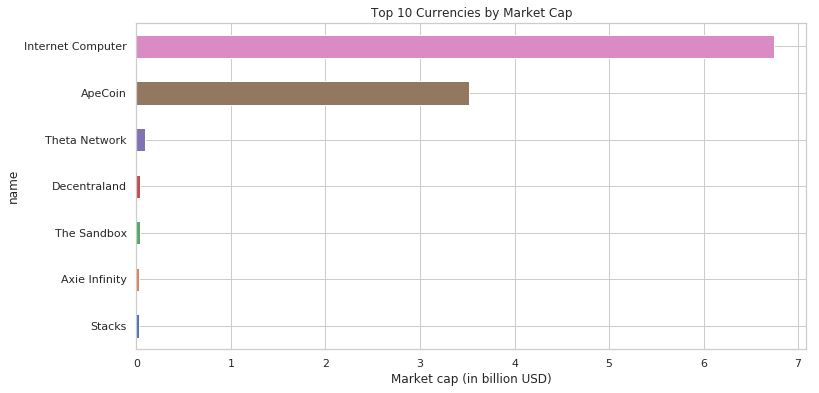

In [256]:
ax = data.groupby(['name'])['market_billion'].last().sort_values(ascending=False).head(10).sort_values().plot(kind='barh');
ax.set_xlabel("Market cap (in billion USD)");
plt.title("Top 10 Currencies by Market Cap");

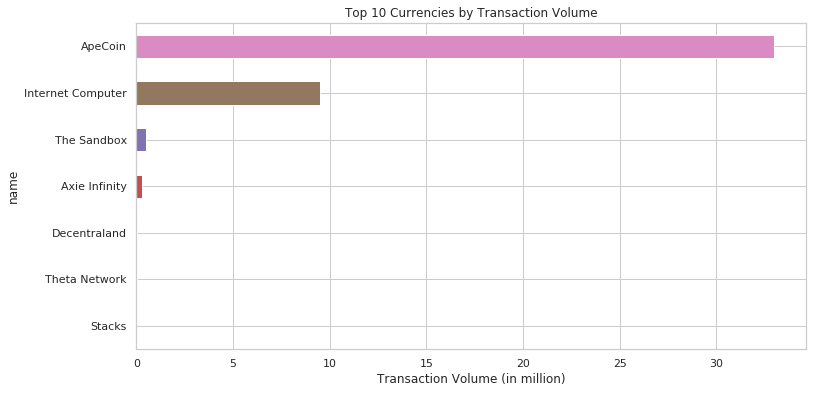

In [257]:
ax = data.groupby(['name'])['volume_million'].last().sort_values(ascending=False).head(10).sort_values().plot(kind='barh');
ax.set_xlabel("Transaction Volume (in million)");
plt.title("Top 10 Currencies by Transaction Volume");

In [258]:
# For sake of convenience, let's define the top 5 currencies

top_5_currency_names = data.groupby(['name'])['market'].last().sort_values(ascending=False).head(7).index
data_top_5_currencies = data[data['name'].isin(top_5_currency_names)]
data_top_5_currencies.head(5)
print(top_5_currency_names)

Index(['Internet Computer', 'ApeCoin', 'Theta Network', 'Decentraland',
       'The Sandbox', 'Axie Infinity', 'Stacks'],
      dtype='object', name='name')


In [259]:
data_top_5_currencies.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread,market_billion,volume_million,volume_billion
count,269.00,269.00,269.00,269.00,269.00,269.00,269.00,269.00,269.00,269.00,269.00,269.00
mean,59.31,7.03,9.45,4.84,6.66,6512919870.72,1760765694.06,0.42,4.61,1.76,6.51,6512919870.72
std,14.25,18.35,23.80,12.75,17.12,11989475126.68,2086548217.56,0.25,12.55,2.09,11.99,11989475126.68
min,28.00,0.03,0.03,0.00,0.03,181369.34,21598612.63,0.00,0.01,0.02,0.00,181369.34
25%,50.00,0.43,0.63,0.35,0.46,811132515.78,574250486.62,0.19,0.20,0.57,0.81,811132515.78
50%,62.00,1.12,1.49,0.86,1.16,2496472487.05,1074354895.01,0.43,0.63,1.07,2.50,2496472487.05
75%,67.00,5.05,6.39,3.82,5.05,7554327903.93,1861161580.98,0.62,2.50,1.86,7.55,7554327903.93
max,87.00,138.20,165.37,121.03,138.29,103861212952.30,12367095438.10,0.98,107.74,12.37,103.86,103861212952.30


## Trend Charts

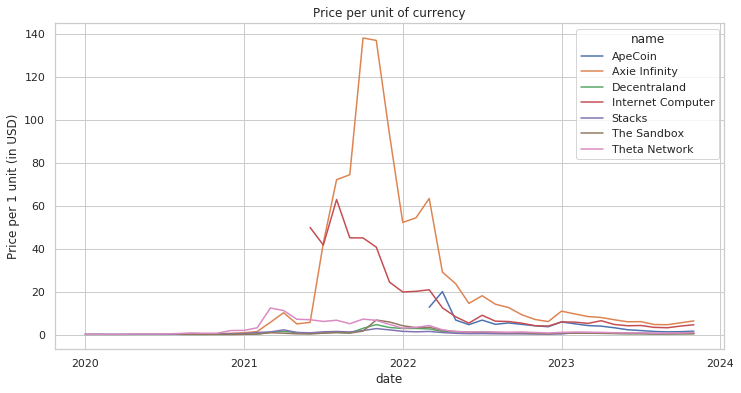

In [260]:
ax = data_top_5_currencies.groupby(['date', 'name'])['close'].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)");
plt.title("Price per unit of currency");

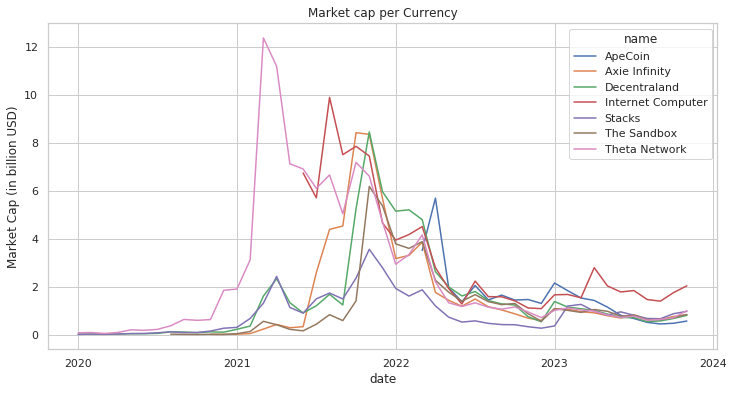

In [261]:
ax = data_top_5_currencies.groupby(['date', 'name'])['market_billion'].mean().unstack().plot();
ax.set_ylabel("Market Cap (in billion USD)");
plt.title("Market cap per Currency");

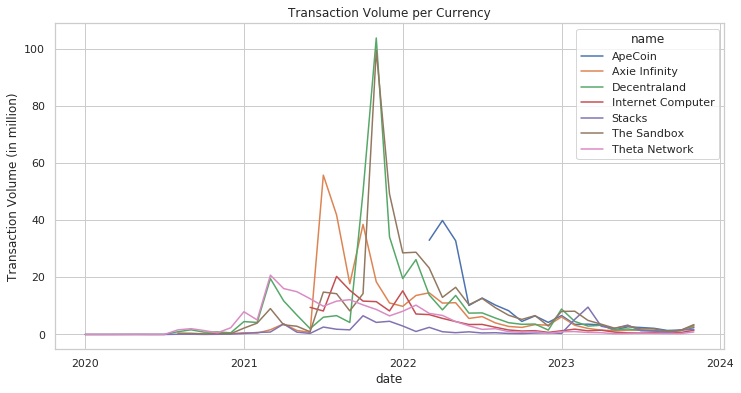

In [262]:
ax = data_top_5_currencies.groupby(['date', 'name'])['volume_million'].mean().unstack().plot();
ax.set_ylabel("Transaction Volume (in million)");
plt.title("Transaction Volume per Currency");

## Trend Charts in 2017

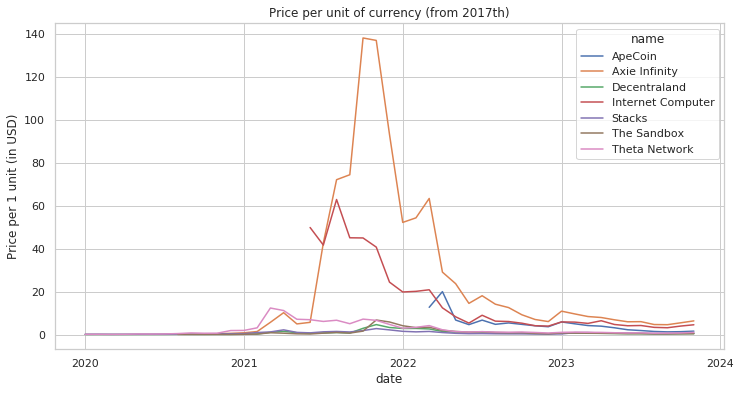

In [263]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2018].groupby(['date', 'name'])['close'].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)");
plt.title("Price per unit of currency (from 2017th)");

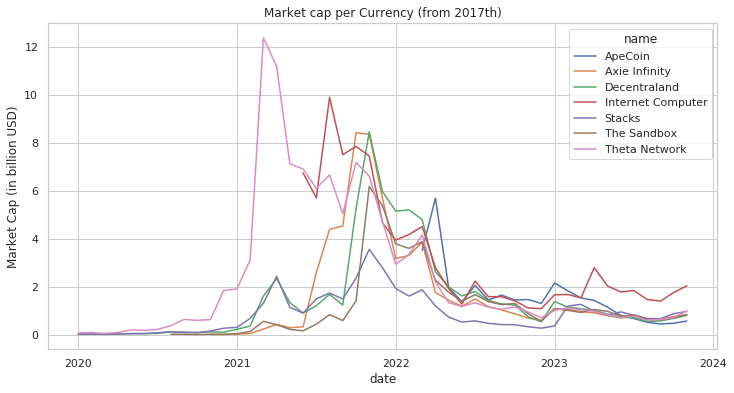

In [264]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2017].groupby(['date', 'name'])['market_billion'].mean().unstack().plot();
ax.set_ylabel("Market Cap (in billion USD)");
plt.title("Market cap per Currency (from 2017th)");

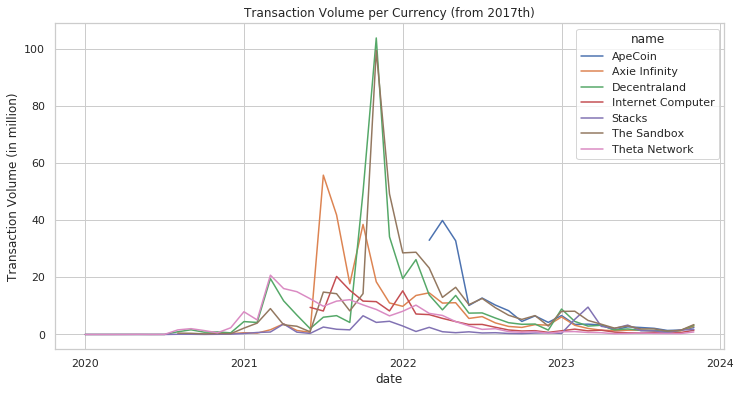

In [265]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2017].groupby(['date', 'name'])['volume_million'].mean().unstack().plot();
ax.set_ylabel("Transaction Volume (in million)");
plt.title("Transaction Volume per Currency (from 2017th)");

## Trend Charts in 2018

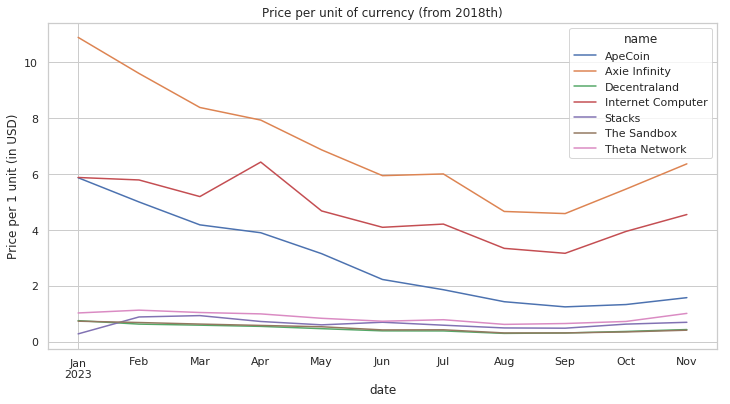

In [266]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2023].groupby(['date', 'name'])['close'].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)");
plt.title("Price per unit of currency (from 2018th)");

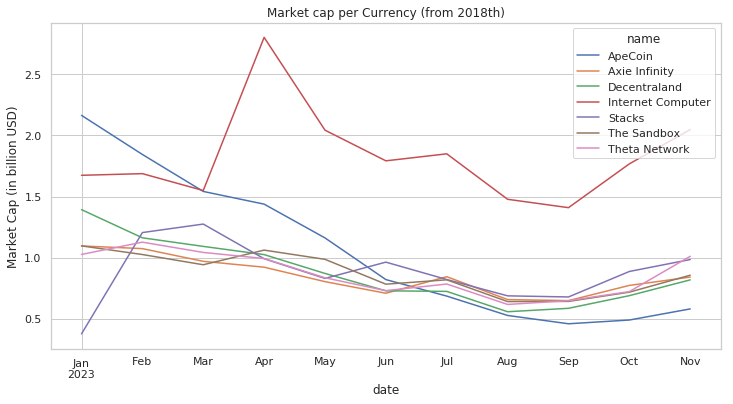

In [267]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2023].groupby(['date', 'name'])['market_billion'].mean().unstack().plot();
ax.set_ylabel("Market Cap (in billion USD)");
plt.title("Market cap per Currency (from 2018th)");

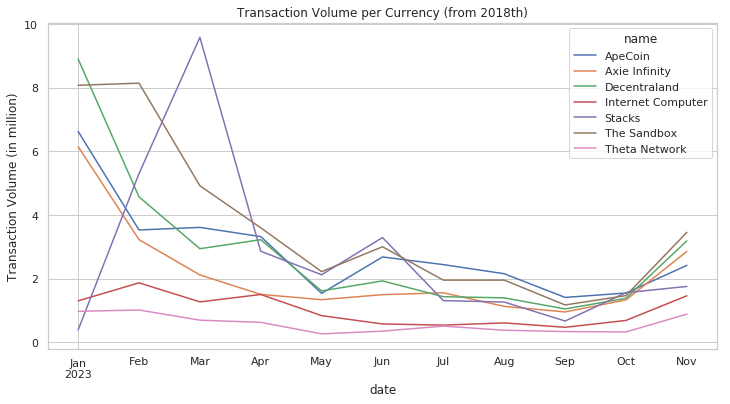

In [268]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2023].groupby(['date', 'name'])['volume_million'].mean().unstack().plot();
ax.set_ylabel("Transaction Volume (in million)");
plt.title("Transaction Volume per Currency (from 2018th)");

## Correlation

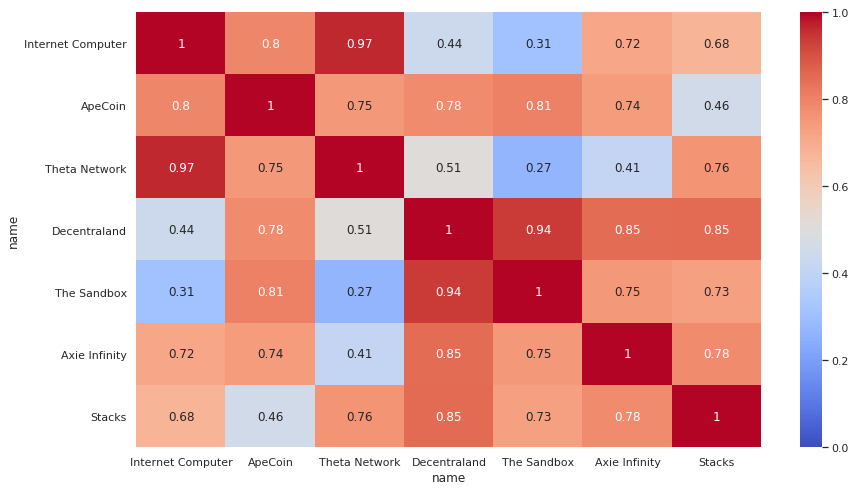

In [269]:
plt.figure(figsize=(14,8))
sns.heatmap(wide_format[top_5_currency_names].corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True);

## Experiments

Small experiment - let's assume that we invested some amount (say - 1000 USD) at some point. Let's see what ROI would we have.

In [270]:
def plot_roi(amount, df):
    ((amount / df.iloc[0]) * df).plot(figsize=(12,8))

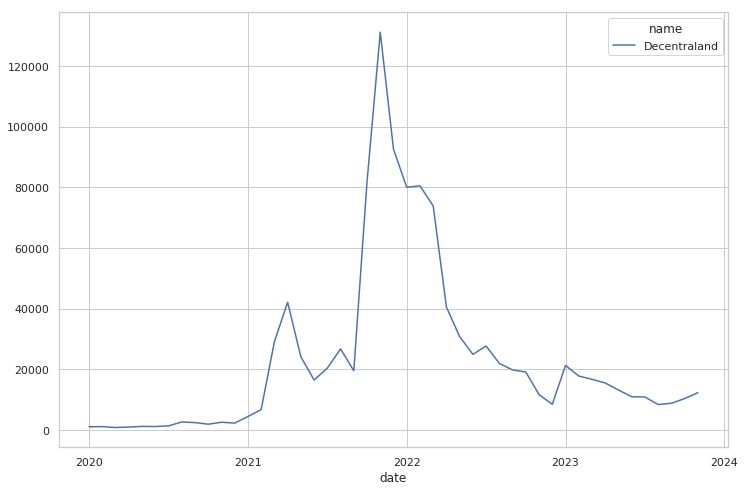

In [271]:
plot_roi(1000, wide_format[['Decentraland']])

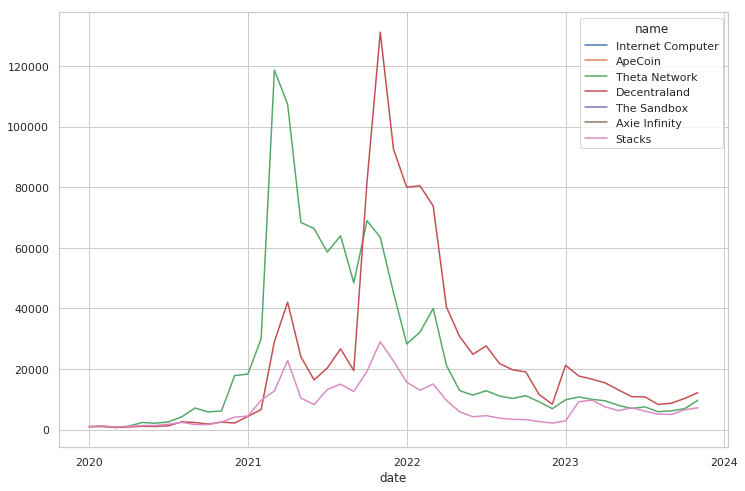

In [272]:
wide_format_2017th = wide_format[(wide_format.index.year >= 2017)]
plot_roi(1000, wide_format_2017th[top_5_currency_names])

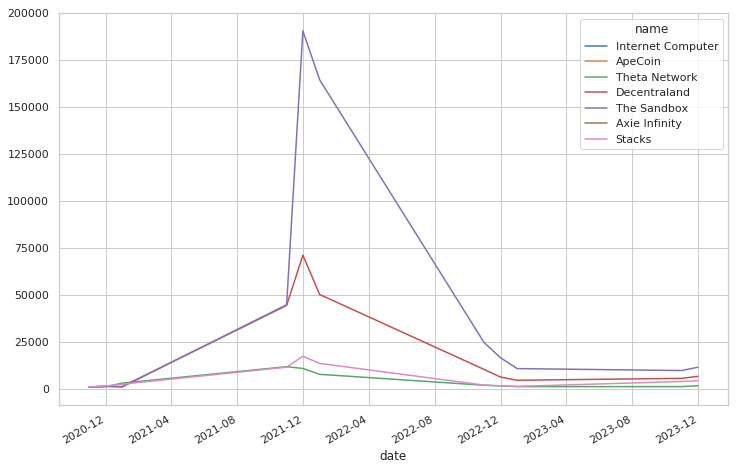

In [273]:
wide_format_late_2017th = wide_format[(wide_format.index.year >= 2017) & (wide_format.index.month >= 10)]
plot_roi(1000, wide_format_late_2017th[top_5_currency_names])

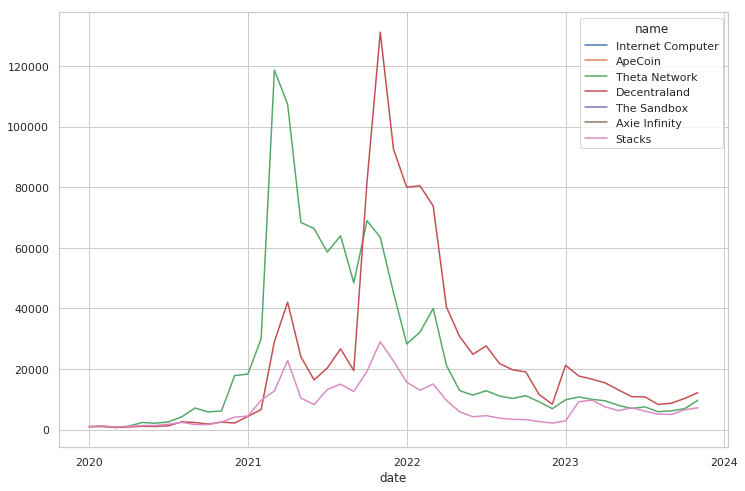

In [274]:
wide_format_2018th = wide_format[(wide_format.index.year >= 2018)]
plot_roi(1000, wide_format_2018th[top_5_currency_names])

In [275]:
len(data.slug.unique())

7

In [276]:
# Some common filters that we might be using
# is_bitcoin = data['symbol'] == 'BTC'
# is_ethereum = data['symbol'] == 'ETH'
# is_ripple  = data['symbol'] == 'XRP'

is_axs = data['symbol'] == 'AXS'
is_mana = data['symbol'] == 'MANA'
is_sand = data['symbol'] == 'SAND'

# Pull out a part of dataset that only has the most interesting currencies
# data_top_currencies = data[is_bitcoin | is_ethereum | is_ripple]
data_top_currencies = data[is_axs | is_mana | is_sand]

Let's chart out Top cryptocurrencies according to latest reported Market Cap

In [277]:
top10Currencies = data.groupby('name')['market_billion'].last().sort_values(ascending=False).head(10)

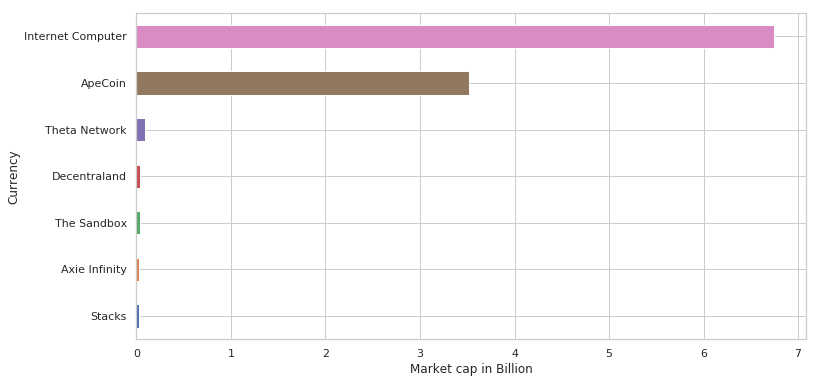

In [278]:
ax = top10Currencies.sort_values().plot(kind='barh')
ax.set_xlabel("Market cap in Billion");
ax.set_ylabel("Currency");

As we can see, and as it was expected, Bitcoin has the highest market cap. Let's see the trend for couple of top currencies.

Text(0,0.5,'Price per 1 unit (in USD)')

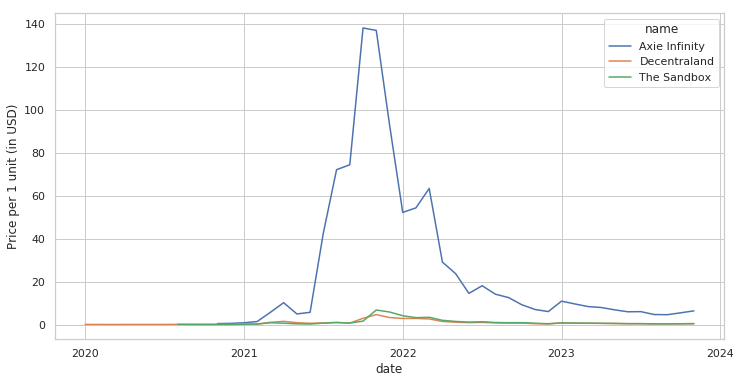

In [279]:
ax = data_top_currencies.groupby(['date', 'name'])['close'].mean().unstack().plot()
ax.set_ylabel("Price per 1 unit (in USD)")

That's rather amusing. Let's see focus on trend starting in 2018th.

Text(20.2,0.5,'Price per 1 unit (in USD)')

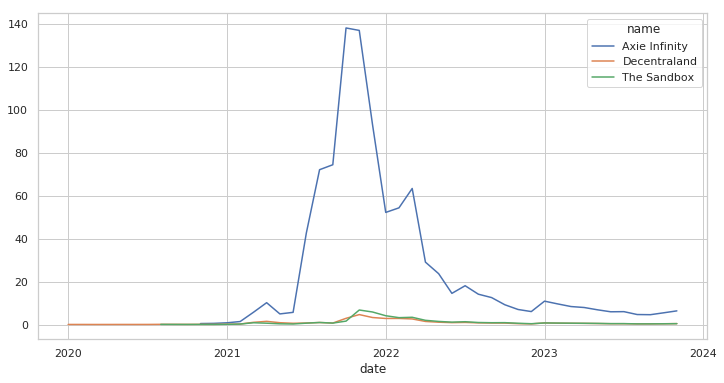

In [280]:
data_top_currencies[data_top_currencies.date.dt.year >= 2018].groupby(['date', 'name'])['close'].mean().unstack().plot()
ax.set_ylabel("Price per 1 unit (in USD)")

We can see that prices have jumped enormously in start and then decreases monotonically with a sharp increase in between Feb and March of 2018th. The cause? Apparently, there are lots of causes. From people's awareness about crypto currencies, to introduction of other currencies that increased the overal need.

## Let's see a trend of Trading Volume for top currencies now

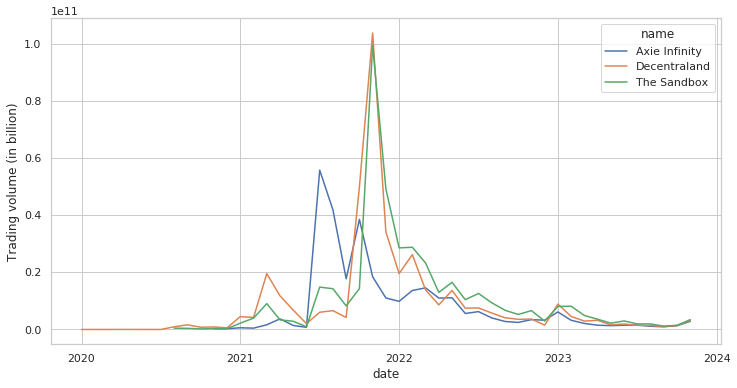

In [281]:
ax = data_top_currencies[data_top_currencies.date.dt.year >= 2018].groupby(['date', 'name'])['volume_billion'].mean().unstack().plot()
ax.set_ylabel("Trading volume (in billion)");

There seems to be a correlation in trading between currencies. Which probably makes sense as, if I understood correctly, most of the currencies are actually traded using Bitcoin (i.e. you have to purchase Bitcoin in order to purchase Ripple). For sake of visibility, I'll plot Bitcoin and other currencies separately. Thing is that Bitcoin prices are actually masking other currencies.

# Experiments


Let's do a small experiment. Let's say that we invested 1000$ in each crypto currency 5 years ago. Let's see how much money would you have now.

First, let's start by drawing a diagram of closing prices for each year for each currency.

In [282]:
def plot_with_textvalue(df):
    ax = df.plot(kind='bar')
    
    ax.set_ylabel("Yearly closing prices (in USD)")

    for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

In [283]:
top10Currencies

name
Internet Computer   6.75
ApeCoin             3.52
Theta Network       0.09
Decentraland        0.04
The Sandbox         0.03
Axie Infinity       0.02
Stacks              0.02
Name: market_billion, dtype: float64

In [284]:
# closing_prices_bitcoin_and_ethereum = data[is_bitcoin | is_ethereum].groupby(['date','name'])['close'].last().unstack().reset_index()
# closing_prices_other_currencies = data[data['name'].isin(top10Currencies.index) & ~is_bitcoin & ~is_ethereum].groupby(['date','name'])['close'].last().unstack().reset_index()

closing_prices_bitcoin_and_ethereum = data[is_mana | is_sand].groupby(['date','name'])['close'].last().unstack().reset_index()
closing_prices_other_currencies = data[data['name'].isin(top10Currencies.index) & ~is_sand & ~is_mana].groupby(['date','name'])['close'].last().unstack().reset_index()

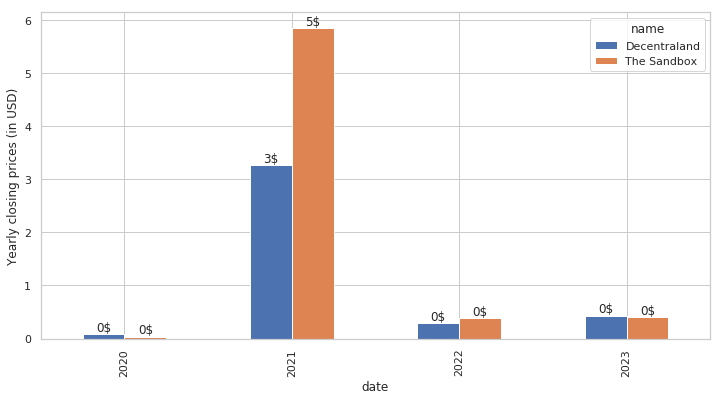

In [285]:
yearly_closing_prices_bitcoin_and_ethereum = closing_prices_bitcoin_and_ethereum.groupby(closing_prices_bitcoin_and_ethereum.date.dt.year).last()
yearly_closing_prices_bitcoin_and_ethereum.drop(columns='date', inplace=True)
plot_with_textvalue(yearly_closing_prices_bitcoin_and_ethereum)

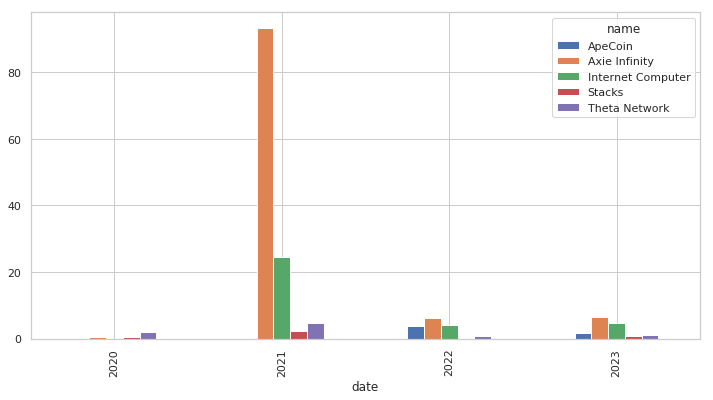

In [286]:
yearly_closing_prices_other_currencies = closing_prices_other_currencies.groupby(closing_prices_other_currencies.date.dt.year).last()
yearly_closing_prices_other_currencies.drop(columns='date', inplace=True)
yearly_closing_prices_other_currencies.plot(kind='bar')

In [287]:
closing_prices_other_currencies.head()

name,date,ApeCoin,Axie Infinity,Internet Computer,Stacks,Theta Network
0,2020-01-31,nan,nan,nan,0.10,0.10
1,2020-02-29,nan,nan,nan,0.12,0.12
2,2020-03-31,nan,nan,nan,0.09,0.07
3,2020-04-30,nan,nan,nan,0.10,0.12
4,2020-05-31,nan,nan,nan,0.13,0.25


Let's plot the closing prices.

In [288]:
closing_prices_bitcoin_and_ethereum.head()

name,date,Decentraland,The Sandbox
0,2020-01-31,0.04,nan
1,2020-02-29,0.04,nan
2,2020-03-31,0.03,nan
3,2020-04-30,0.03,nan
4,2020-05-31,0.04,nan


In [289]:
closing_prices_other_currencies.head()

name,date,ApeCoin,Axie Infinity,Internet Computer,Stacks,Theta Network
0,2020-01-31,nan,nan,nan,0.10,0.10
1,2020-02-29,nan,nan,nan,0.12,0.12
2,2020-03-31,nan,nan,nan,0.09,0.07
3,2020-04-30,nan,nan,nan,0.10,0.12
4,2020-05-31,nan,nan,nan,0.13,0.25


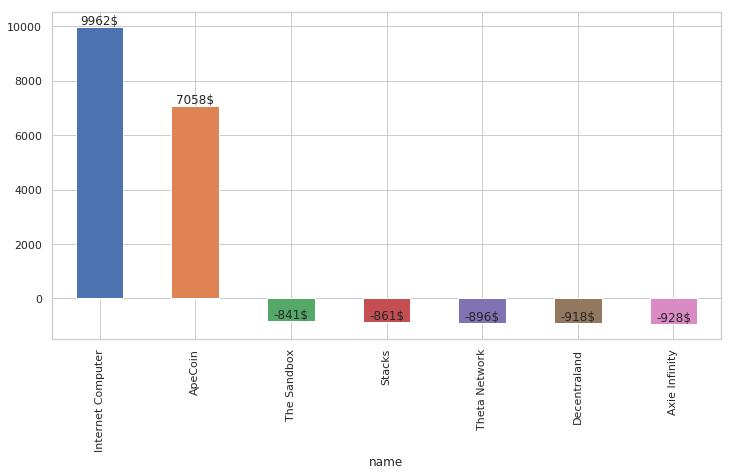

In [290]:
def calc_earnings(currency_name, df):
    #print("Displaying stats for "+currency_name)

    closing_prices = df[(df['name'] == currency_name) & (~df['close'].isnull())][['date', 'close']]

    # Num. currency purchased for 1000$
    #print("Closing price at the beginning: " + str(closing_prices.iloc[0]['close']))

    num_units_purchased = 1000 / closing_prices.iloc[0]['close']
    num_units_purchased

    #print("Num. units purchased: " + str(num_units_purchased))

    # Current value
    last_price = closing_prices.iloc[-1]['close']
    #print("Last price: " + str(last_price))

    amount_earned = (num_units_purchased * last_price) - 1000

    #print("Amount you would have earned: " + str(amount_earned) + "$")
    
    return amount_earned
    
# Borrow the index :-)
top_10_currencies_earnings = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings[currency] = calc_earnings(currency, data)
    
ax = top_10_currencies_earnings.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

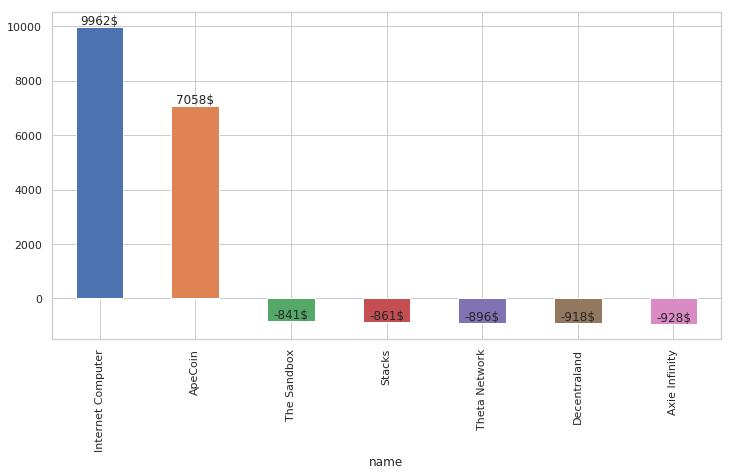

In [291]:
# Borrow the index :-)
top_10_currencies_earnings_2018 = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings_2018[currency] = calc_earnings(currency, data[data.date.dt.year >= 2018])
    
top_10_currencies_earnings_2018

ax = top_10_currencies_earnings_2018.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

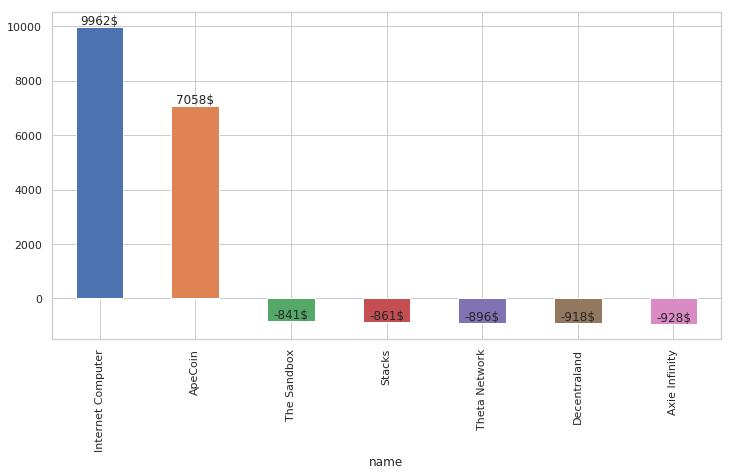

In [292]:
# Borrow the index :-)
top_10_currencies_earnings_2018 = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings_2018[currency] = calc_earnings(currency, data[data.date.dt.year >= 2018])
    
top_10_currencies_earnings_2018

ax = top_10_currencies_earnings_2018.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

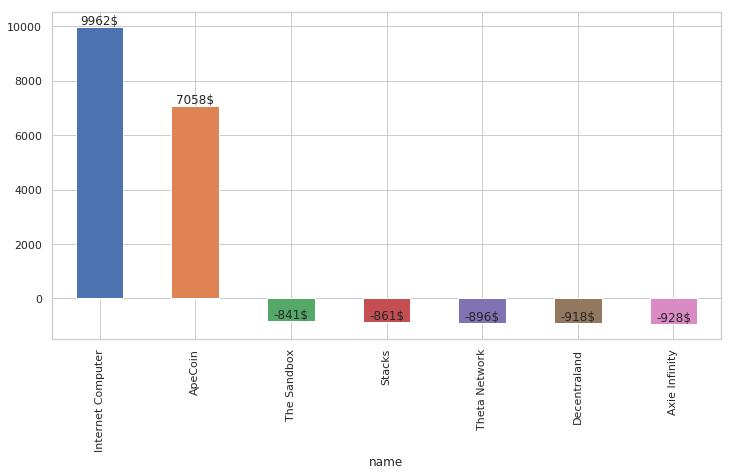

In [293]:
top_10_currencies_earnings_without_nem = top_10_currencies_earnings[top_10_currencies_earnings.index != 'NEM']

ax = top_10_currencies_earnings_without_nem.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

Text(0.5,1,'Correlation Heatmap between Bitcoin and other top 5 Crypto')

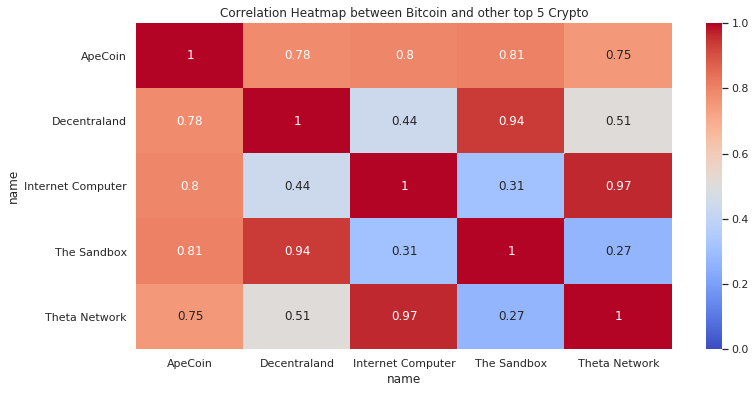

In [294]:
top10Currencies = data.groupby('name')['market_billion'].last().sort_values(ascending=False).head(5)
closing_prices_top10 = data[data['name'].isin(top10Currencies.index)].groupby(['date', 'name'])['close'].mean().unstack()
closing_prices_top10.corr()

plt.figure(figsize=(12,6))
sns.heatmap(closing_prices_top10.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Bitcoin and other top 5 Crypto')

Text(0.5,1,'Correlation Heatmap between Bitcoin and other top 4 Crypto')

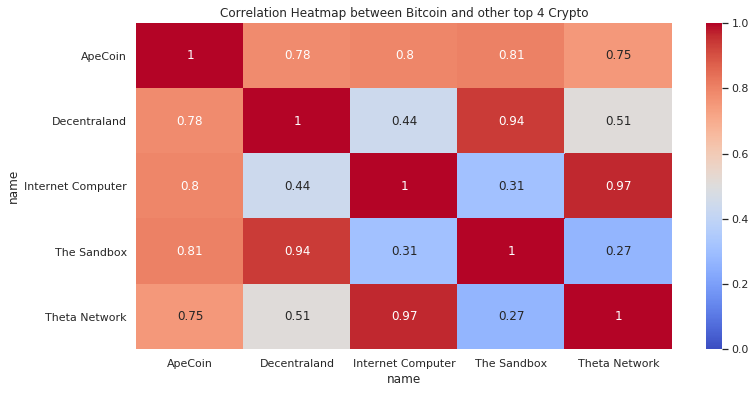

In [295]:
plt.figure(figsize=(12,6))
sns.heatmap(closing_prices_top10.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Bitcoin and other top 4 Crypto')

**Copyright** by [Quanonblocks](https://www.kaggle.com/quanonblocks)


Released under the [Apache 2.0](http://www.apache.org/licenses/LICENSE-2.0) open source license.